# Predicting customer satisfaction via ML

The client is a startup in the logistics and delivery domain, whose main goal is their customers' satisfaction. Getting feedback from customers is not always easy, but it is the one effective way to gauge customers' satisfaction, and improve their operations accordingly. The company provides us with a subset of a bigger survey, and asked to come up with the most effective ML method to predict customers' happiness from their answers to the survey. 

In particular, the company asked to:

1. create a ML model that is at least 73% accurancy in predicting customer's satisfaction;
2. understand which questions are the most crucial to make correct predictions, and which can be removed from the survey without impinging on model accuracy.

## Libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, accuracy_score, classification_report, confusion_matrix, auc, precision_recall_curve, RocCurveDisplay
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

import lazypredict
from lazypredict.Supervised import LazyClassifier

## Data exploration

In [2]:
data = pd.read_csv("ACME-HappinessSurvey2020.csv")
data

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5
...,...,...,...,...,...,...,...
121,1,5,2,3,4,4,3
122,1,5,2,3,4,2,5
123,1,5,3,3,4,4,5
124,0,4,3,3,4,4,5


Data Description:

- Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
- X1 = my order was delivered on time
- X2 = contents of my order was as I expected
- X3 = I ordered everything I wanted to order
- X4 = I paid a good price for my order
- X5 = I am satisfied with my courier
- X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

<Axes: >

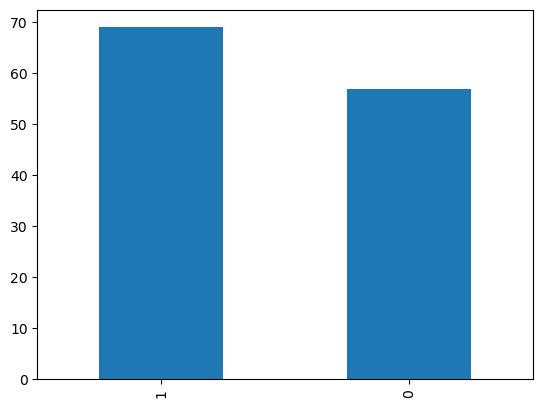

In [3]:
data['Y'].value_counts().plot.bar()

From the plot above, we can see that there were more happy customers than unhappy customers (though the difference between the two is not as big as one may want to).

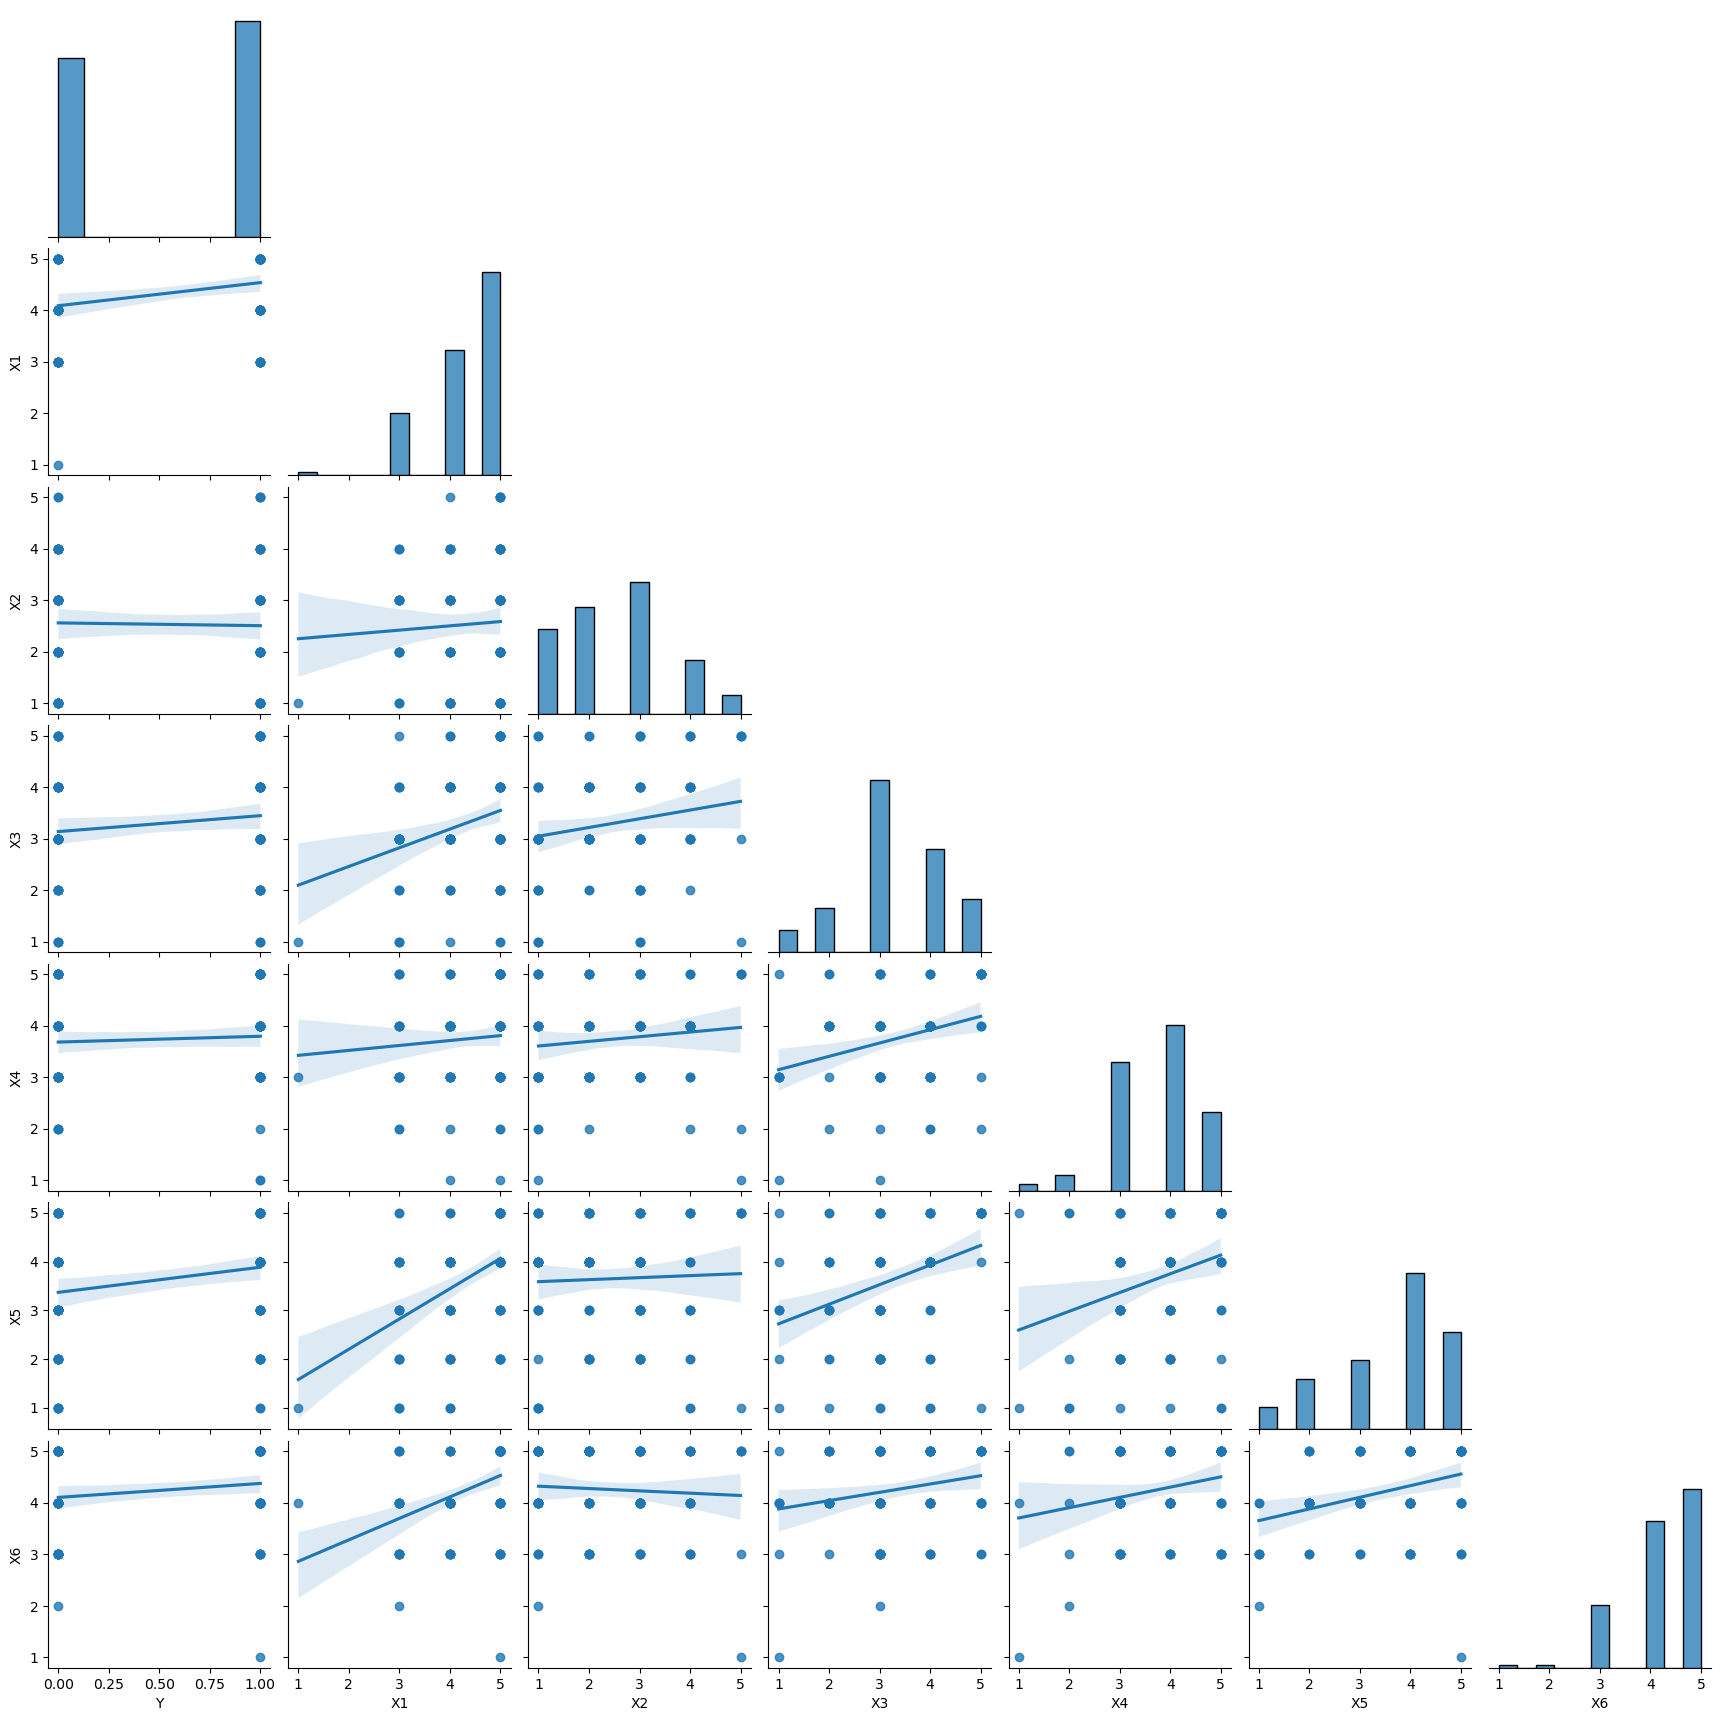

In [4]:
sns.pairplot(data, corner=True, kind='reg')

<Axes: >

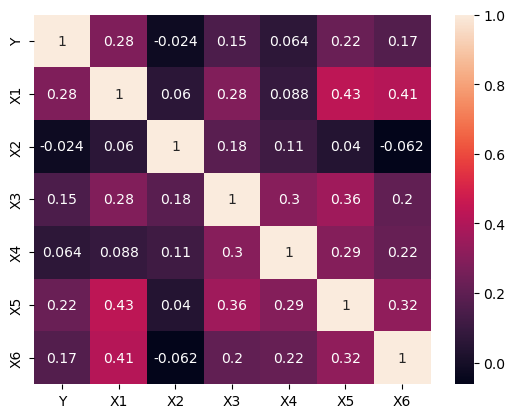

In [5]:
sns.heatmap(data.corr(), annot=True)

As we can see from the correlation heatmap above, it looks like customer happiness correlates more with X1 ('my order was delivered on time') and X5 ('I am satisfied with my courier') than with any other feature. This seems to suggest that customery satisfaction hinges on the experience with courier more than anything else (i.e., order content, price, and app experience).

Notably, X1 ('my order was delivered on time') highly correlates with and X3 ('I ordered everything I wanted to order'), X5 ('I am satisfied with my courier') and X6 ('the app makes ordering easy for me'). All other combinations had lesser correlation coefficients (< 0.1).

Therefore, it looks like X2 ('The content of my order was as I expected') and X4 ('I paid a good price for my order') are not so informative, and may be removed from analysis.

## Modelling

First, let's split the data so that the features *Xn* are separated from the to-be-predicted feature *y* (customer happiness). Then, we split the dataset in two subsets: the _train_ set of *Xn* and *y* features will be used to identify the right ML algorithm to predict customer happiness; the _test_ set will be used to evaluate the chosen algorithm by comparing the predicted *y* values with the true *y* values.

In [7]:
np.random.seed(1)
X = data.drop('Y', axis=1)
y = data['Y']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # split the dataset

The `LazyClassifier` class allows us to run all possible estimators, and compare their accuracy scores in one line.

In [9]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

models

100%|█████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 10.61it/s]

[LightGBM] [Info] Number of positive: 53, number of negative: 47
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530000 -> initscore=0.120144
[LightGBM] [Info] Start training from score 0.120144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,0.62,0.59,0.59,0.62,0.01
AdaBoostClassifier,0.62,0.57,0.57,0.61,0.08
BaggingClassifier,0.58,0.54,0.54,0.57,0.02
BernoulliNB,0.58,0.54,0.54,0.57,0.01
NuSVC,0.58,0.54,0.54,0.57,0.01
LGBMClassifier,0.54,0.53,0.53,0.54,0.05
LabelSpreading,0.54,0.51,0.51,0.54,0.01
XGBClassifier,0.54,0.51,0.51,0.54,0.12
DummyClassifier,0.54,0.51,0.51,0.54,0.01


The most accurate predictions were made by the Decision Tree and the Ada Boost classifiers. However, none of them actually reached our target accuracy threshold (73%). This means that both models are indeed promising in making good predictions for our case, though they might need (i) some hyperparameter tuning (i.e., identification of the best combination of parameters), and/or (ii) some feature selection (i.e., elimination of some features that might be either information, or, more dangerously, noisy, and impede more accurate predictions). 

### Feature selection

In [37]:
# define feature selection
fs = SelectKBest(score_func=f_classif, k=3)
# apply feature selection
X_selected = fs.fit_transform(X, y)

X_selected_train, X_selected_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2)

### Hyperparameter Turning -- KFolding + Crossvalidation via Grid Search

In [58]:
best_models = models.sort_values(by='Accuracy', ascending=False).index.tolist()
best_models = best_models[:2]
best_models.append('RandomForestClassifier')

best_models

['DecisionTreeClassifier', 'AdaBoostClassifier', 'RandomForestClassifier']

In [39]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = dict().fromkeys(best_models)
param_grid['DecisionTreeClassifier'] = {'max_depth': [1, 2, 3]}
param_grid['AdaBoostClassifier'] = {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [50, 100, 200]}
param_grid['RandomForestClassifier'] = {'n_estimators': [50, 100, 200], 'max_depth': [1, 2, 3]}

param_grid

{'DecisionTreeClassifier': {'max_depth': [1, 2, 3]},
 'AdaBoostClassifier': {'learning_rate': [0.01, 0.1, 1],
  'n_estimators': [50, 100, 200]},
 'RandomTreeClassifier': None,
 'RandomForestClassifier': {'n_estimators': [50, 100, 200],
  'max_depth': [1, 2, 3]}}

In [59]:
def load_model(name):
    if name == "DecisionTreeClassifier":
        model = DecisionTreeClassifier()
    elif name == "AdaBoostClassifier":
        model = AdaBoostClassifier()
    elif name == "RandomForestClassifier":
        model = RandomForestClassifier() 
    return model 

In [61]:
for model in best_models:
    estimator = load_model(model)
    clf = GridSearchCV(estimator = estimator, param_grid = param_grid[model], cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_selected_train, y=y_train, cv=outer_cv)
    gscv = clf.fit(X_selected_train, y_train)
    dict_models[model] = gscv.best_estimator_
    y_pred = dict_models[model].predict(X_selected_test)
    print("\n Report of the model: ", dict_models[model],"\n", classification_report(y_test, y_pred),"\n")


 Report of the model:  DecisionTreeClassifier(max_depth=2) 
               precision    recall  f1-score   support

           0       0.59      0.83      0.69        12
           1       0.78      0.50      0.61        14

    accuracy                           0.65        26
   macro avg       0.68      0.67      0.65        26
weighted avg       0.69      0.65      0.65        26
 


 Report of the model:  AdaBoostClassifier(learning_rate=0.01, n_estimators=200) 
               precision    recall  f1-score   support

           0       0.56      0.75      0.64        12
           1       0.70      0.50      0.58        14

    accuracy                           0.62        26
   macro avg       0.63      0.62      0.61        26
weighted avg       0.64      0.62      0.61        26
 


 Report of the model:  RandomForestClassifier(max_depth=3, n_estimators=200) 
               precision    recall  f1-score   support

           0       0.50      0.33      0.40        12
        

None of the algorithms above seems able to reach the target accuracy (73% or higher), even after stratified K-fold cross validation. Even more complex classification algorithms such as the MLP Classifier seem unable to reach our target accuracy:

In [72]:
from sklearn.neural_network import MLPClassifier

mlp_param_grid = {
    'hidden_layer_sizes' : [(100,), (50,), (20,), (10,)],
    'activation' : ['relu', 'logistic', 'identity'],
    'solver' : ['adam', 'lbfgs', 'sgd'], 
    'alpha' : [0.0001, 0.001, 0.01, 1],
    'learning_rate_init' : [0.001, 0.01],
    'tol' : [0.0001, 0.001, 0.01, 1],
}

mlp = GridSearchCV(estimator = MLPClassifier(), param_grid = mlp_param_grid, cv=5)
mlp_gcsv = mlp.fit(X_selected_train, y_train)
mlp_y_pred = mlp_gcsv.best_estimator_.predict(X_selected_test)
print(classification_report(y_test, mlp_y_pred))

              precision    recall  f1-score   support

           0       0.44      0.33      0.38        12
           1       0.53      0.64      0.58        14

    accuracy                           0.50        26
   macro avg       0.49      0.49      0.48        26
weighted avg       0.49      0.50      0.49        26

